# **Klasifikasi Gambar intel**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan intel menggunakan gambar.

## **Sumber Dataset**
https://www.kaggle.com/datasets/puneet6060/intel-image-classification

# **Import Libraries**

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhamadfahmi284","key":"30b5697e972ad803a7cf5eb39ab11490"}'}

In [4]:
# Download kaggle dataset and unzip the file
import os
os.makedirs('/root/.kaggle', exist_ok=True)

# memindahkan dan atur permission file kaggle.json
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification

#unzip dataset
!unzip intel-image-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain

## **Gabungkan Data Train dan Data Test ke Direktori yang Sama**

In [5]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

# Direktori baru untuk dataset gabungan
combined_dir = "intel_klasifikasi/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## **Plot gambar sampel untuk semua kelas**

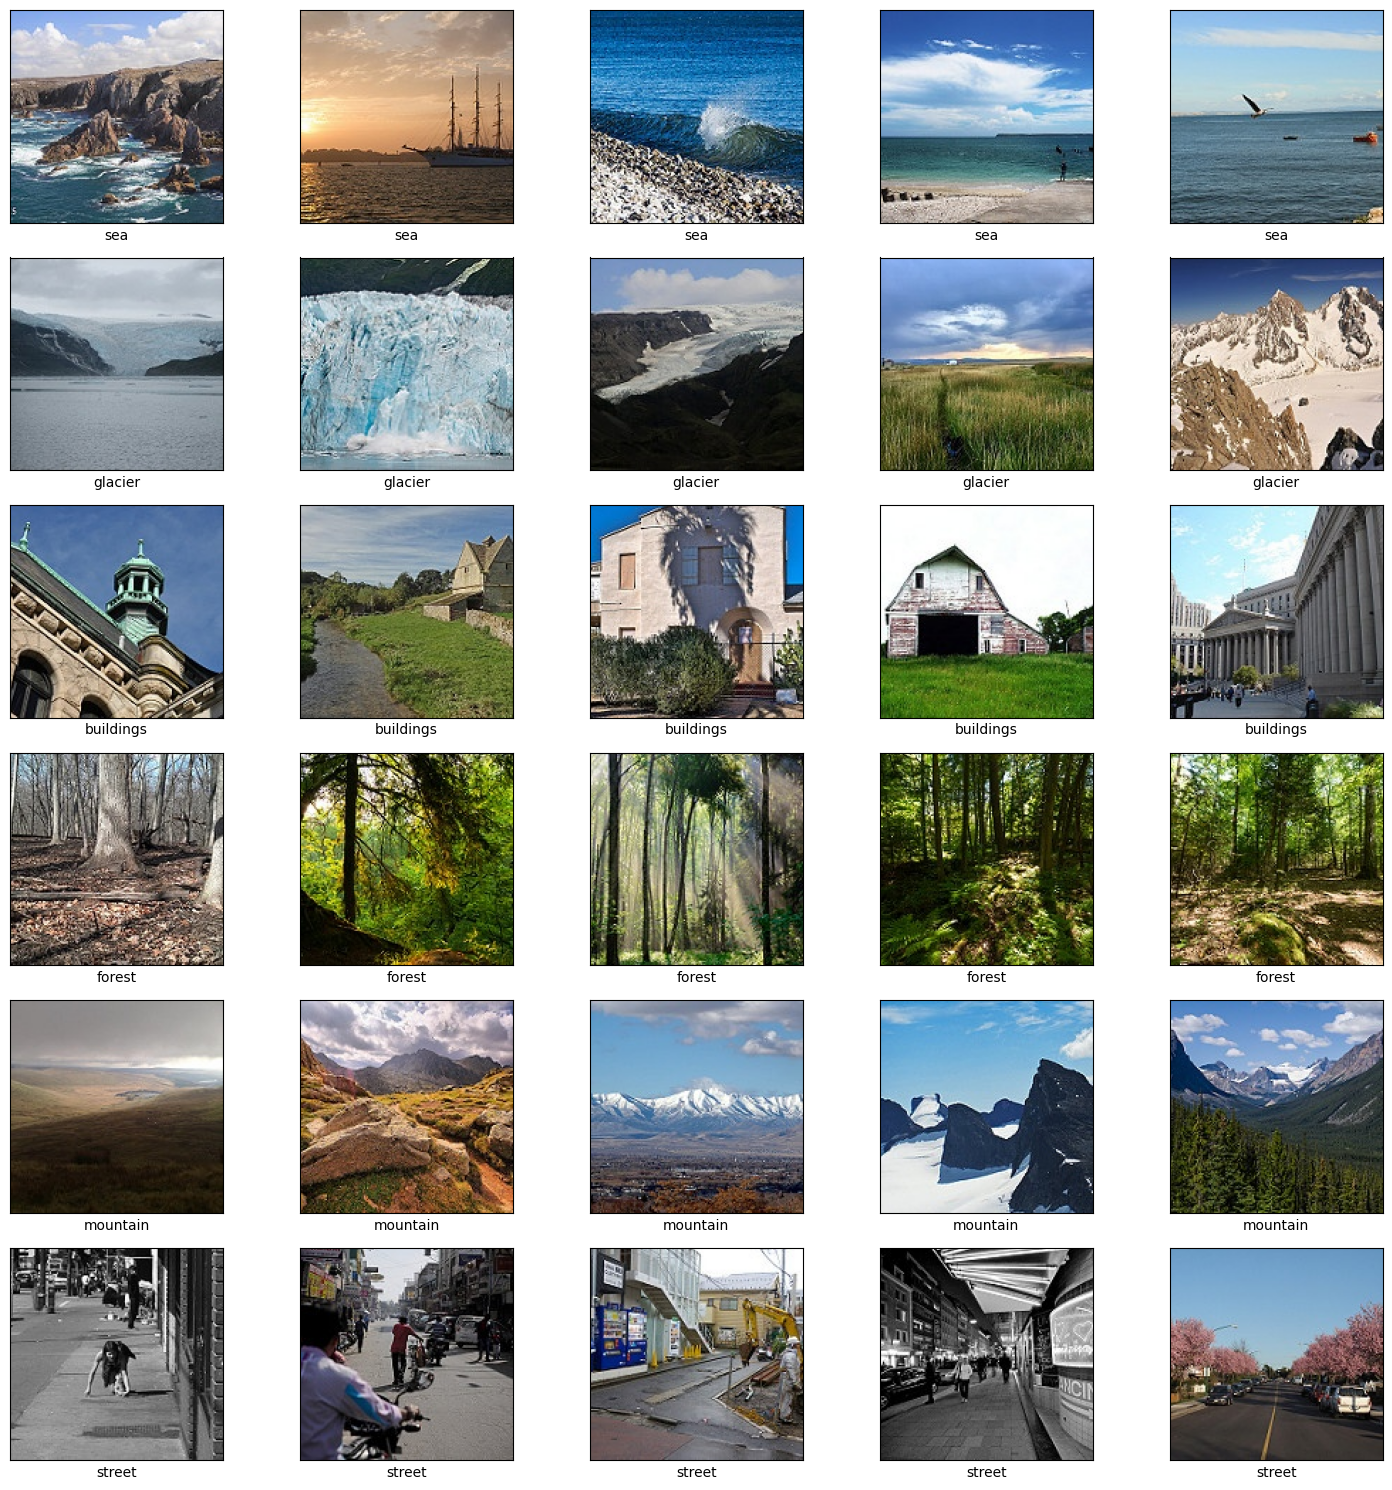

In [6]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "intel_klasifikasi/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "intel_klasifikasi/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## **Plot distribusi gambar di seluruh kelas**

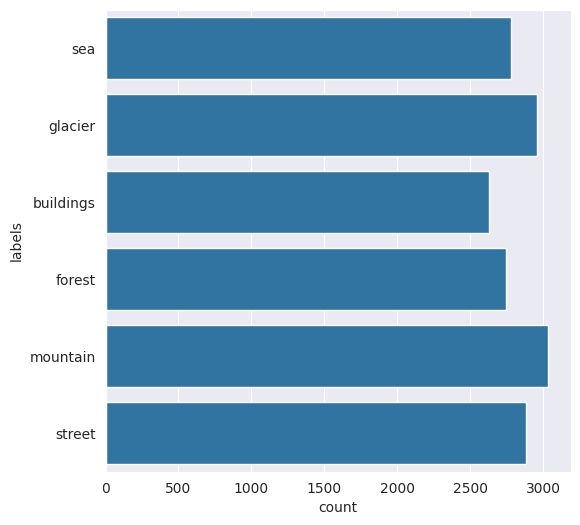

In [7]:
# Define source path
lung_path = "intel_klasifikasi/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Augmentation**

Proses augmentasi gambar adalah teknik yang digunakan untuk membuat variasi baru dari setiap gambar dalam dataset, sehingga model memiliki lebih banyak variasi untuk dipelajari. Ini membantu mencegah overfitting, di mana model terlalu terbiasa dengan data pelatihan dan tidak dapat menggeneralisasi dengan baik ke data baru.

Berikut adalah beberapa strategi augmentasi gambar yang dapat kita terapkan:

- `anticlockwise_rotation` adalah ketika gambar diputar ke arah berlawanan dengan arah jarum jam.
- `clockwise_rotation` adalah ketika gambar diputar ke arah searah dengan arah jarum jam.
- `flip_up_down` adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- `sheared` adalah ketika gambar diberikan efek pergeseran acak.
- `blur` adalah ketika gambar diberikan efek kabur atau blur.
- `wrap_shift` adalah ketika gambar diberikan efek pergeseran melengkung.
- `brightness` adalah ketika gambar diberikan efek peningkatan kecerahan.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io, img_as_ubyte
import numpy as np
import random
import cv2
import os

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224)).numpy()
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [9]:
import os
import random
import tensorflow as tf
from skimage import io, img_as_ubyte
import cv2

# Transformasi (anggap semua fungsi sudah didefinisikan)
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Path asli
images_path = "intel_klasifikasi/dataset"

# Parameter augmentasi
images_to_generate = 500
max_attempts = 10

# Loop ke semua folder label di dataset
for label_name in os.listdir(images_path):
    label_path = os.path.join(images_path, label_name)
    if not os.path.isdir(label_path):
        continue  # skip kalau bukan folder


# Ambil semua gambar dari folder asli
print(f"\n🚀 Mulai augmentasi label: {label_name}")
images = [os.path.join(label_path, im) for im in os.listdir(label_path) if im.lower().endswith(('.jpg', '.jpeg', '.png'))]




# Augmentasi
i = 1
while i <= images_to_generate:
    success = False
    attempts = 0

    while not success and attempts < max_attempts:
        image_path = random.choice(images)
        try:
            original_image = io.imread(image_path)

            if original_image.ndim not in [3, 4]:
                raise ValueError("Invalid image dimensions")

            transformed_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
            if tf.reduce_max(transformed_image) > 1.0:
                    transformed_image = transformed_image / 255.0

                # Terapkan 1 atau beberapa transformasi
            transformation_count = random.randint(1, len(transformations))

            for _ in range(transformation_count):
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)

            if isinstance(transformed_image, tf.Tensor):
                transformed_image = transformed_image.numpy()



            transformed_image = img_as_ubyte(transformed_image)

            # Simpan hasil augmentasi ke folder asli dengan nama unik
            new_image_path = os.path.join(images_path, f"aug_image_{i}.jpg")
            cv2.imwrite(new_image_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))

            print(f"[{i}/{images_to_generate}] Saved: {new_image_path}")
            i += 1
            success = True

        except Exception as e:
            print(f"Could not read or process the image {image_path}: {e}, skipping...")
            attempts += 1

print("Augmentasi selesai!")



🚀 Mulai augmentasi label: street
Could not read or process the image intel_klasifikasi/dataset/street/14266.jpg: Images of type float must be between -1 and 1., skipping...
[1/500] Saved: intel_klasifikasi/dataset/aug_image_1.jpg
[2/500] Saved: intel_klasifikasi/dataset/aug_image_2.jpg
[3/500] Saved: intel_klasifikasi/dataset/aug_image_3.jpg
[4/500] Saved: intel_klasifikasi/dataset/aug_image_4.jpg
[5/500] Saved: intel_klasifikasi/dataset/aug_image_5.jpg
Could not read or process the image intel_klasifikasi/dataset/street/11116.jpg: Images of type float must be between -1 and 1., skipping...
Could not read or process the image intel_klasifikasi/dataset/street/1556.jpg: Images of type float must be between -1 and 1., skipping...
Could not read or process the image intel_klasifikasi/dataset/street/2.jpg: Images of type float must be between -1 and 1., skipping...
[6/500] Saved: intel_klasifikasi/dataset/aug_image_6.jpg
[7/500] Saved: intel_klasifikasi/dataset/aug_image_7.jpg
Could not re

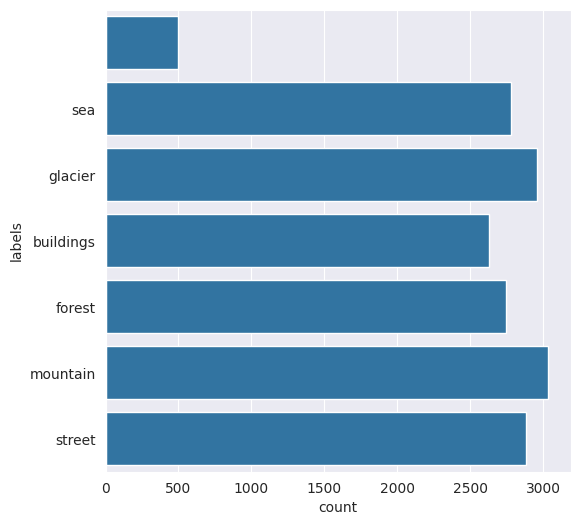

In [10]:
# Define source path
lung_path = "intel_klasifikasi/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Splitting : Training and Testing**

In [11]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'intel_klasifikasi/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
              500
buildings    2628
forest       2745
glacier      2957
mountain     3037
sea          2784
street       2883
dtype: int64

In [12]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [13]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [14]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 14027
test size 3507


In [15]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test                  88
       buildings     568
       forest        543
       glacier       565
       mountain      636
       sea           531
       street        576
train                412
       buildings    2060
       forest       2202
       glacier      2392
       mountain     2401
       sea          2253
       street       2307
dtype: int64 


                                              path    labels    set
11762      intel_klasifikasi/dataset/sea/11526.jpg       sea  train
8262       intel_klasifikasi/dataset/sea/24301.jpg       sea  train
12188      intel_klasifikasi/dataset/sea/23069.jpg       sea  train
11344    intel_klasifikasi/dataset/street/7863.jpg    street  train
16060  intel_klasifikasi/dataset/mountain/6012.jpg  mountain   test


In [16]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "intel_klasifikasi/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [17]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **Image Data Generator**

In TensorFlow you can do this through the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to do:
- Configure the random transformation and normalization operations to be performed on the image data during training
- Instantiate generator of augmented image sets (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. This generator can then be used with `tf.keras` model methods which accept generator data as input, `fit`, `evaluate` and `predict`

Prepare the training and validation data, to begin with using `.flow_from_directory()` which generates image datasets and their labels directly in their respective folders by setting the `WIDTH` and `HEIGHT` size, predefined `BATCH SIZE` size and mode its class. Here we use `"binary"` class mode because the number of classes used is 2.

In [18]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_buildings = os.path.join(TRAIN_DIR + '/buildings')
train_forest = os.path.join(TRAIN_DIR + '/forest')
train_mountain = os.path.join(TRAIN_DIR + '/mountain')
test_buildings = os.path.join(TEST_DIR + '/buildings')
test_forest = os.path.join(TEST_DIR + '/forest')
test_mountain = os.path.join(TEST_DIR + '/mountain')

print("Total number of buildings images in training set: ",len(os.listdir(train_buildings)))
print("Total number of forest images in training set: ",len(os.listdir(train_forest)))
print("Total number of mountain images in training set: ",len(os.listdir(train_mountain)))
print("Total number of buildings images in test set: ",len(os.listdir(test_buildings)))
print("Total number of forest images in test set: ",len(os.listdir(test_forest)))
print("Total number of mountain images in test set: ",len(os.listdir(test_mountain)))

Total number of buildings images in training set:  2060
Total number of forest images in training set:  2202
Total number of mountain images in training set:  2401
Total number of buildings images in test set:  568
Total number of forest images in test set:  543
Total number of mountain images in test set:  636


In [19]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              color_mode='rgb',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 10894 images belonging to 6 classes.
Found 2721 images belonging to 6 classes.
Found 3419 images belonging to 6 classes.


In [20]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

# **Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):**

In [21]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_1 = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (4,4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (7,7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [22]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_1= model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.3527 - loss: 2.9812 - val_accuracy: 0.3988 - val_loss: 2.4414 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.5110 - loss: 1.3294 - val_accuracy: 0.6545 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6291 - loss: 1.0498 - val_accuracy: 0.6994 - val_loss: 0.7952 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6798 - loss: 0.9115 - val_accuracy: 0.7446 - val_loss: 0.8235 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7273 - loss: 0.7940 - val_accuracy: 0.6454 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7461 - loss: 0.7771 - val_accuracy: 0.7446 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7644 - loss: 0.6991

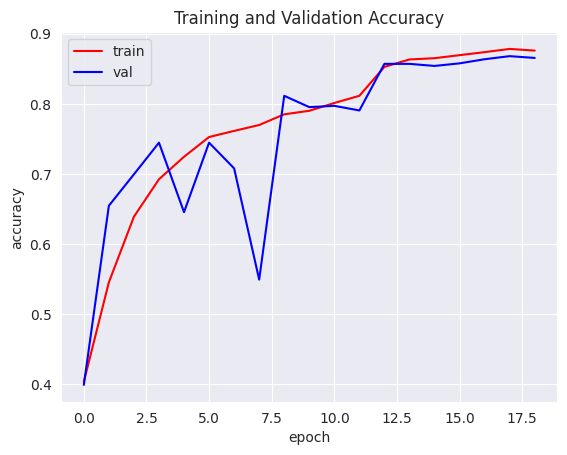

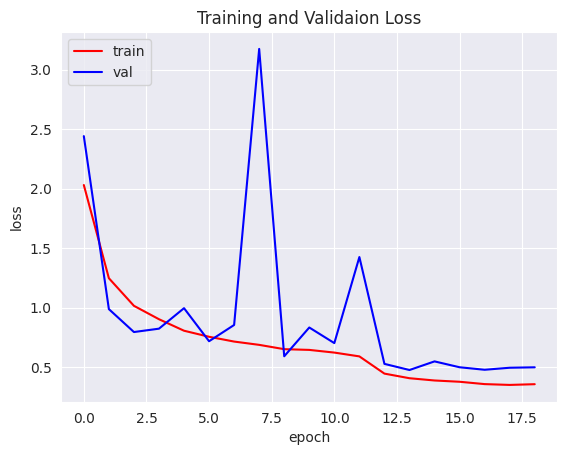

In [24]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8479    0.8539    0.8509       568
      forest     0.9831    0.9613    0.9721       543
     glacier     0.8147    0.7858    0.8000       565
    mountain     0.7714    0.8648    0.8154       636
         sea     0.8954    0.8060    0.8484       531
      street     0.8621    0.8681    0.8651       576

    accuracy                         0.8567      3419
   macro avg     0.8624    0.8567    0.8586      3419
weighted avg     0.8594    0.8567    0.8571      3419



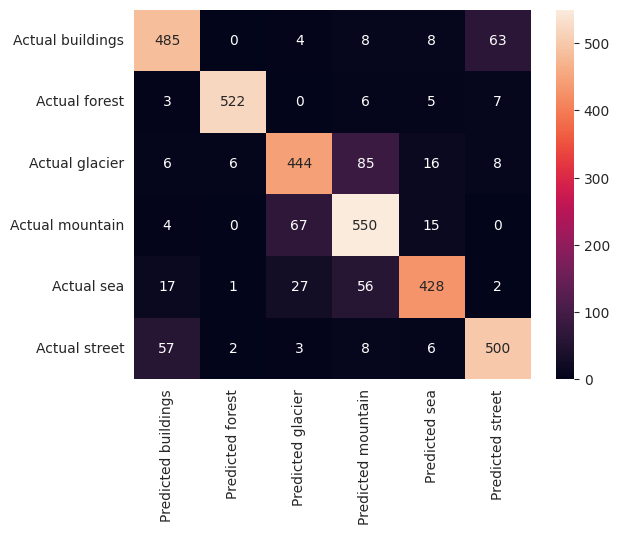

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_1 = model_1.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_1, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Model Exp 2 - CNN Architecture Using 64 Neurons in Conv Layer:**

1. Add 3 convolutional layers with each layer have 64 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [26]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_2 = Sequential([
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(64, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(64, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_2.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,931,910 (11.18 MB)

 Trainable params: 2,931,526 (11.18 MB)

 Non-trainable params: 384 (1.50 KB)

In [27]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_2= model_2.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.3006 - loss: 4.4952 - val_accuracy: 0.2260 - val_loss: 3.2075 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.2930 - loss: 1.6440 - val_accuracy: 0.2789 - val_loss: 1.6719 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.3520 - loss: 1.5036 - val_accuracy: 0.4186 - val_loss: 1.3381 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.4177 - loss: 1.3533 - val_accuracy: 0.3815 - val_loss: 2.3284 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.4579 - loss: 1.2816 - val_accuracy: 0.4862 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.4907 - loss: 1.2346 - val_accuracy: 0.5050 - val_loss: 1.8965 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.5093 - l

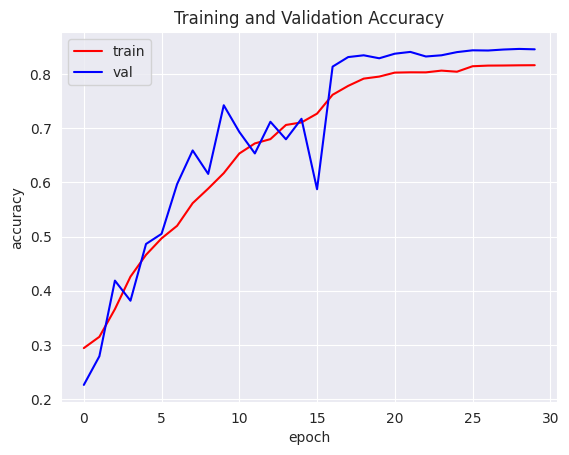

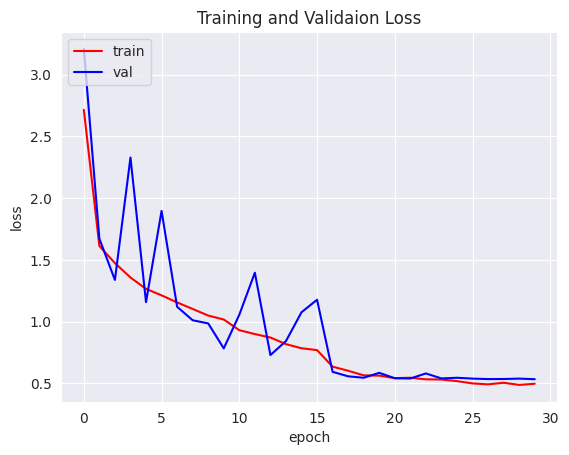

In [29]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



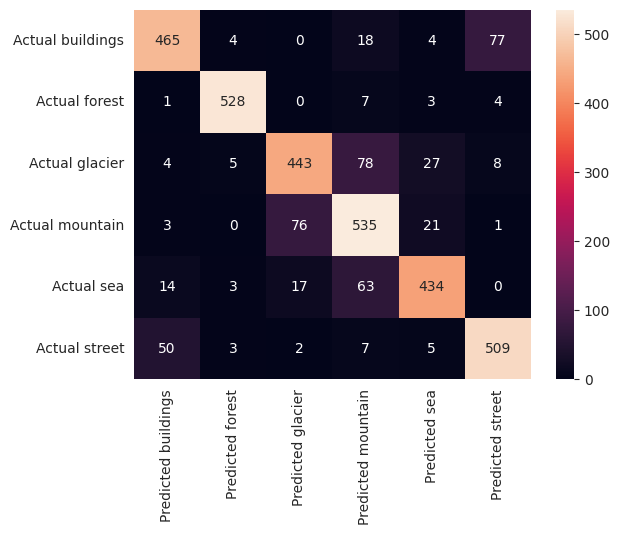

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_2 = model_2.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Model Exp 3 - CNN Architecture Using 128 Neurons in Conv Layer:**

1. Add 3 convolutional layers with each layer have 128 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good



In [31]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_3 = Sequential([
    Conv2D(128, (3,3),  padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(128, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(128, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_3.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,387,526 (24.37 MB)

 Trainable params: 6,386,758 (24.36 MB)

 Non-trainable params: 768 (3.00 KB)

In [32]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_3= model_3.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 62s 150ms/step - accuracy: 0.2858 - loss: 7.8486 - val_accuracy: 0.3194 - val_loss: 2.0801 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.2514 - loss: 1.7493 - val_accuracy: 0.3080 - val_loss: 4.2699 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.2523 - loss: 1.7002 - val_accuracy: 0.2848 - val_loss: 1.6248 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.2851 - loss: 1.6397 - val_accuracy: 0.3580 - val_loss: 1.5529 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.2863 - loss: 1.6454 - val_accuracy: 0.3021 - val_loss: 2.2502 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - accuracy: 0.2977 - loss: 1.6408 - val_accuracy: 0.3565 - val_loss: 1.6708 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.3

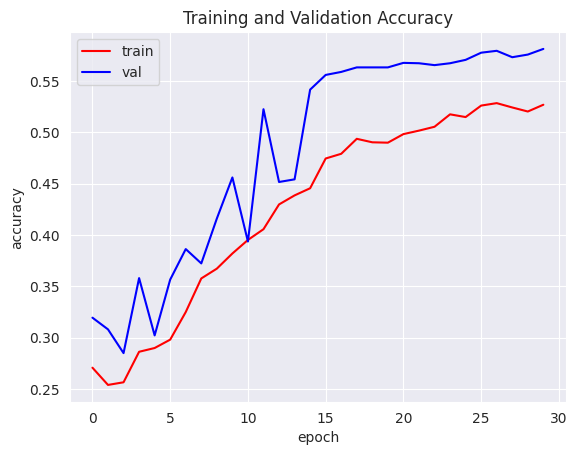

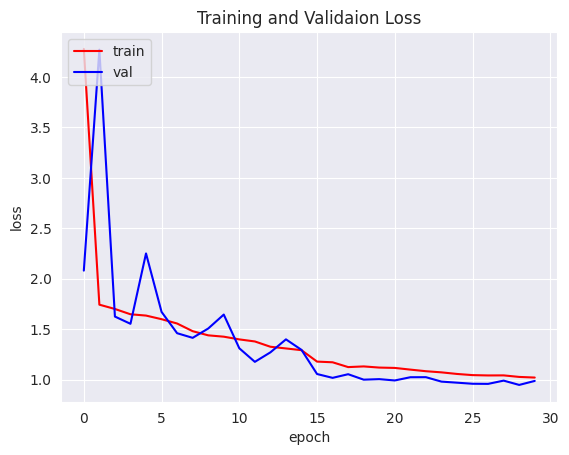

In [34]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



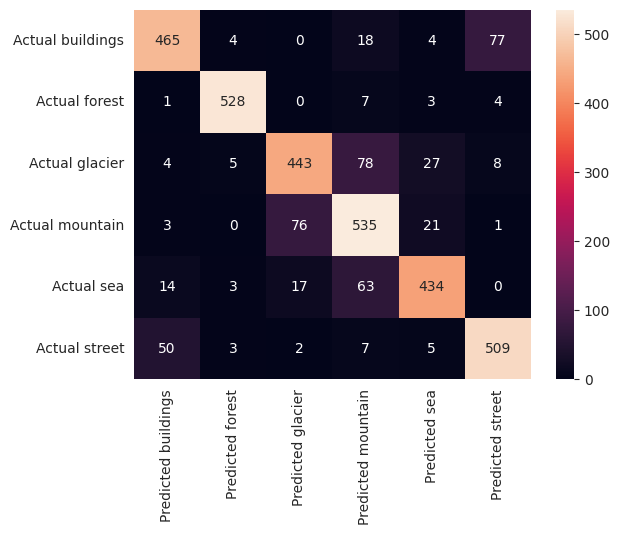

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_3 = model_3.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Model Exp 4 - CNN Architecture (Using Learning Rate 0.001):**

In [36]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_4 = Sequential([
    Conv2D(32, (3,3),  padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_4.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [37]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_4= model_4.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.3660 - loss: 2.7481 - val_accuracy: 0.3186 - val_loss: 1.9489 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.4898 - loss: 1.3473 - val_accuracy: 0.5671 - val_loss: 1.1447 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6093 - loss: 1.0901 - val_accuracy: 0.6409 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6716 - loss: 0.9125 - val_accuracy: 0.7060 - val_loss: 0.8685 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6957 - loss: 0.8414 - val_accuracy: 0.7115 - val_loss: 0.8353 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7279 - loss: 0.7816 - val_accuracy: 0.5237 - val_loss: 1.4480 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7460 - l

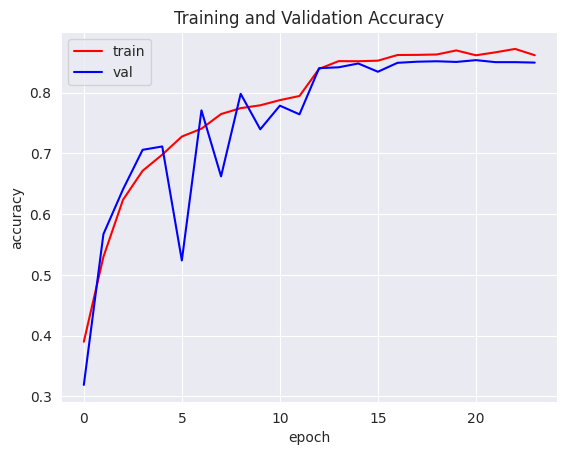

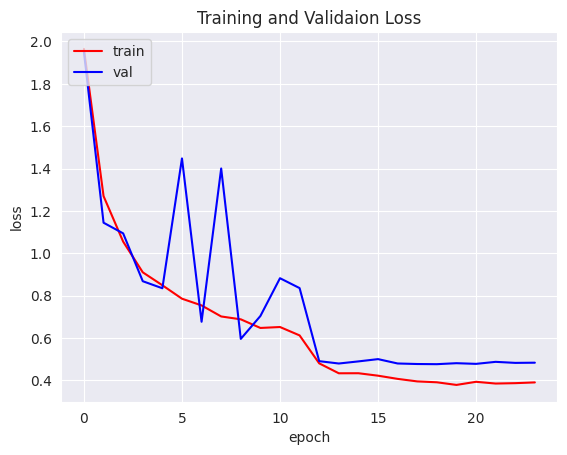

In [39]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



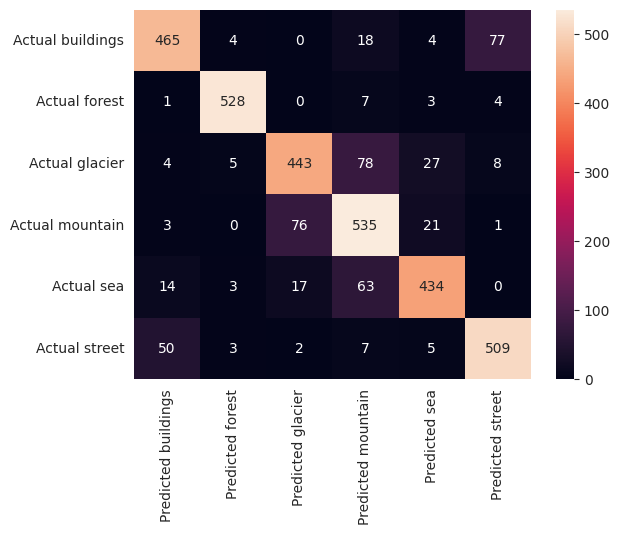

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_4 = model_4.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Model Exp 5 - CNN Architecture (Using Learning Rate 0.0001):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer with learning rate 0.0001
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [41]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_5 = Sequential([
    Conv2D(32, (3,3),  padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_5.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [42]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_5= model_5.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.3642 - loss: 2.4923 - val_accuracy: 0.4329 - val_loss: 1.7474 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.4889 - loss: 1.3694 - val_accuracy: 0.6057 - val_loss: 1.0801 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6091 - loss: 1.0823 - val_accuracy: 0.6931 - val_loss: 0.8598 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6625 - loss: 0.9323 - val_accuracy: 0.6883 - val_loss: 0.8451 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7155 - loss: 0.8233 - val_accuracy: 0.5410 - val_loss: 1.3662 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7360 - loss: 0.7814 - val_accuracy: 0.6487 - val_loss: 1.0727 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7588 - l

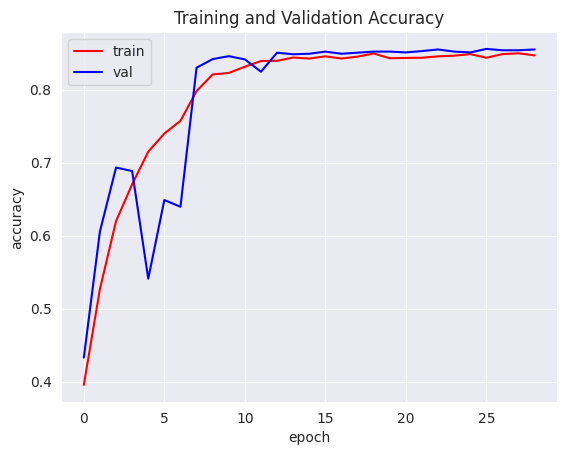

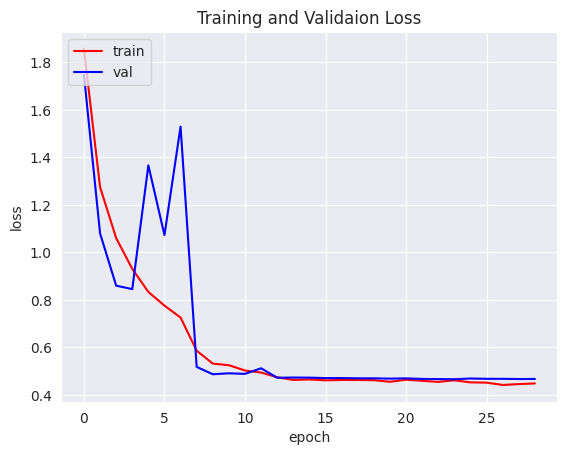

In [44]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



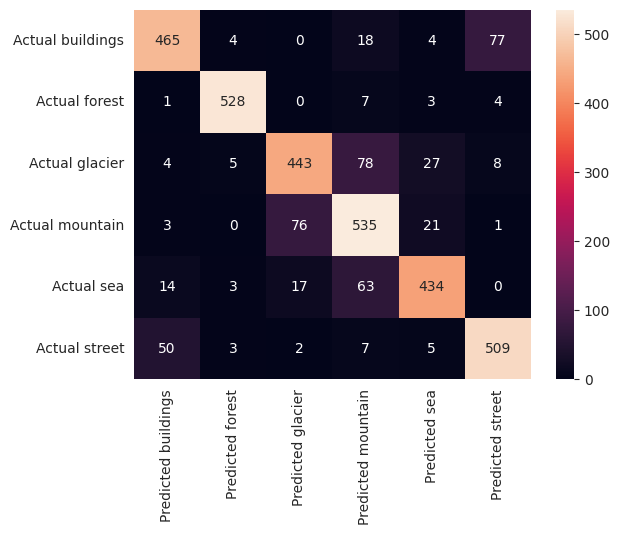

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_5 = model_5.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Model Exp 6 - CNN Architecture (Using Learning Rate 0.00001):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer with learning rate 0.00001
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good

In [46]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_6 = Sequential([
    Conv2D(32, (3,3),  padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_6.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_6.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [47]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_6= model_6.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.3738 - loss: 2.7366 - val_accuracy: 0.4509 - val_loss: 1.4905 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5144 - loss: 1.3091 - val_accuracy: 0.6968 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6263 - loss: 1.0565 - val_accuracy: 0.6226 - val_loss: 1.0421 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6873 - loss: 0.8896 - val_accuracy: 0.7064 - val_loss: 1.0059 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7168 - loss: 0.8200 - val_accuracy: 0.6454 - val_loss: 1.4518 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7542 - loss: 0.7115 - val_accuracy: 0.8159 - val_loss: 0.5746 - learning_rate: 1.0000e-04
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7859

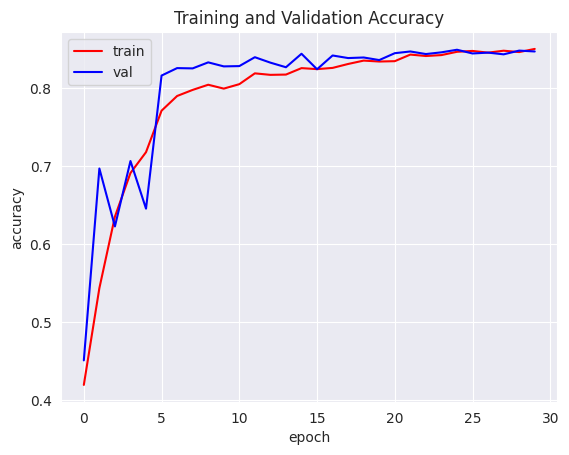

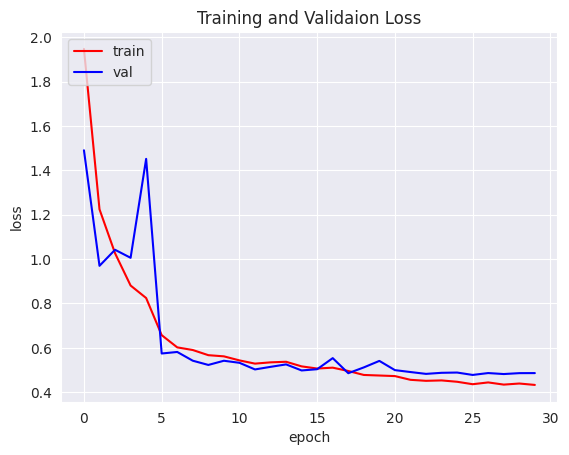

In [49]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



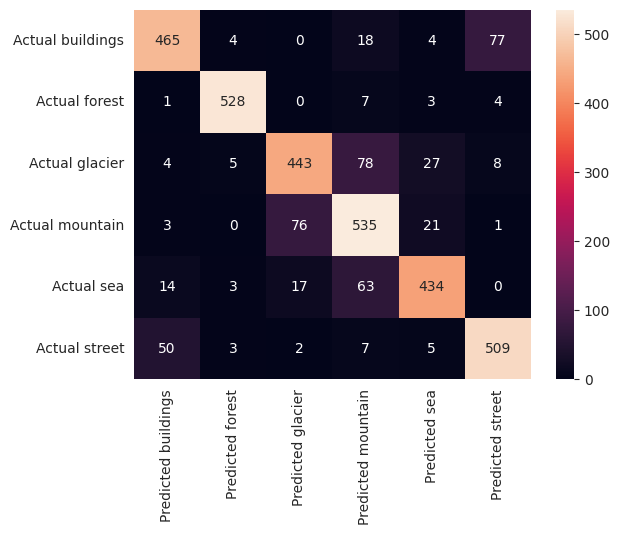

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_6 = model_6.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Model Exp 7 - CNN Architecture (Using Adam as Optimizer):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take Adam as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [51]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_7 = Sequential([
    Conv2D(32, (3,3),  padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_7.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_7.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [52]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_7= model_7.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.3566 - loss: 3.0180 - val_accuracy: 0.3216 - val_loss: 3.7427 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5155 - loss: 1.3717 - val_accuracy: 0.6373 - val_loss: 0.9612 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6050 - loss: 1.0912 - val_accuracy: 0.5406 - val_loss: 1.2029 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6452 - loss: 0.9885 - val_accuracy: 0.4667 - val_loss: 1.4438 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6758 - loss: 0.8850 - val_accuracy: 0.5586 - val_loss: 2.7102 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7320 - loss: 0.7378 - val_accuracy: 0.8015 - val_loss: 0.6153 - learning_rate: 1.0000e-04
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7621

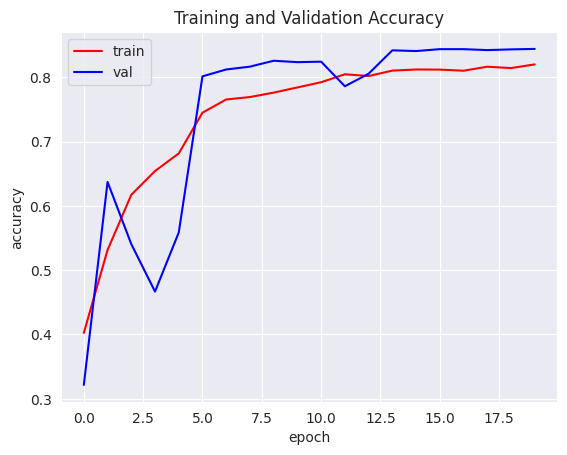

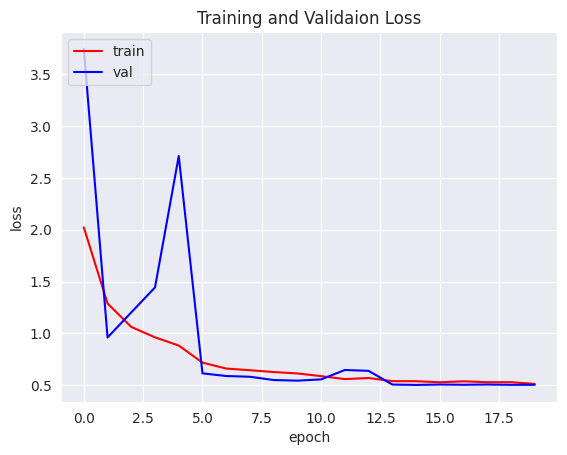

In [54]:
acc = history_7.history['accuracy']
val_acc = history_7.history['val_accuracy']
loss = history_7.history['loss']
val_loss = history_7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



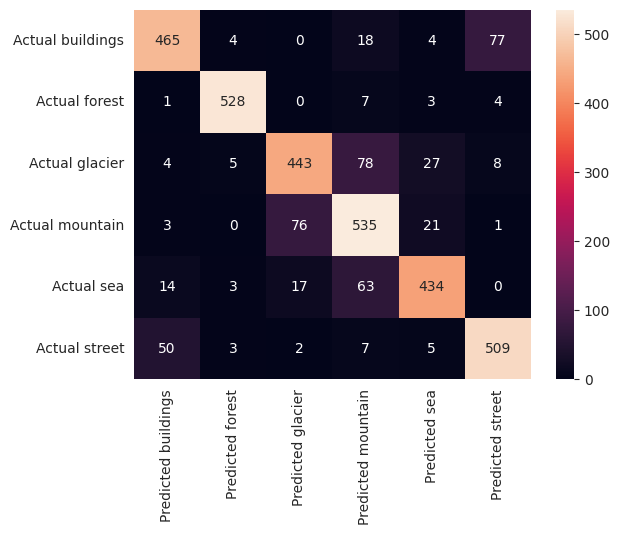

In [55]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_7 = model_7.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Model Exp 8 - CNN Architecture (Using SGD as Optimizer):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take SGD as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [56]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_8 = Sequential([
    Conv2D(32, (3,3),  padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_8.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_8.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [57]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_8= model_8.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.3507 - loss: 3.0949 - val_accuracy: 0.4969 - val_loss: 1.3320 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.4975 - loss: 1.3640 - val_accuracy: 0.5913 - val_loss: 1.1116 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6267 - loss: 1.0289 - val_accuracy: 0.5377 - val_loss: 2.4462 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6821 - loss: 0.8620 - val_accuracy: 0.7468 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7319 - loss: 0.7692 - val_accuracy: 0.6722 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7446 - loss: 0.7550 - val_accuracy: 0.6086 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7780 - l

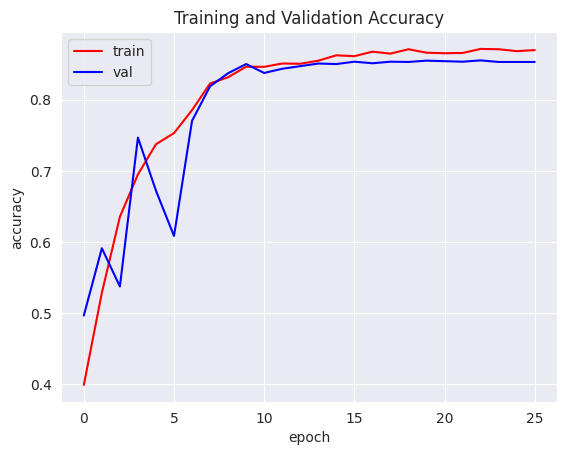

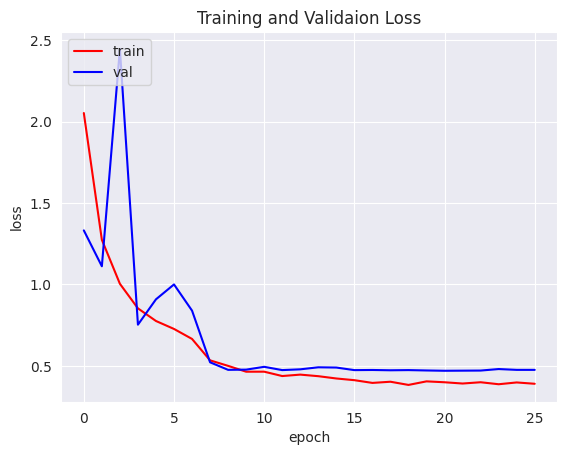

In [59]:
acc = history_8.history['accuracy']
val_acc = history_8.history['val_accuracy']
loss = history_8.history['loss']
val_loss = history_8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



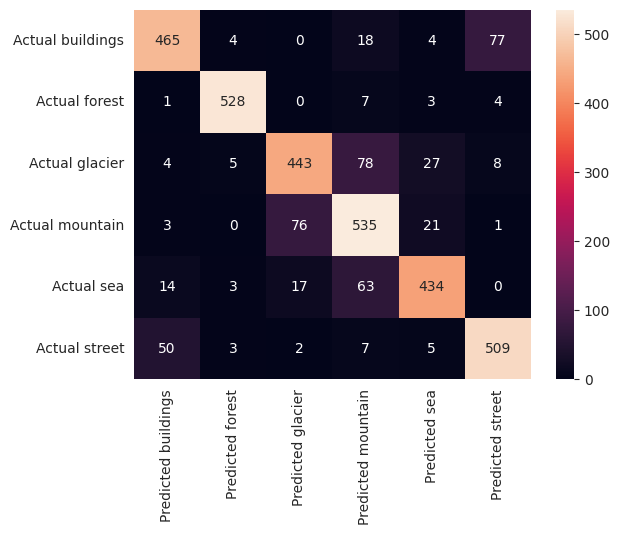

In [60]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_8 = model_8.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

In [61]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_final = Sequential([
    Conv2D(32, (3,3),  padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (4,4),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32, (7,7),  padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamic output units
])

model_final.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_final.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [62]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [63]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model training with validation
history_final= model_final.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.3412 - loss: 3.0036 - val_accuracy: 0.4035 - val_loss: 1.4816 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.5187 - loss: 1.3519 - val_accuracy: 0.4517 - val_loss: 1.4888 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6278 - loss: 1.0678 - val_accuracy: 0.5369 - val_loss: 1.1840 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6848 - loss: 0.8952 - val_accuracy: 0.7291 - val_loss: 0.8309 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7254 - loss: 0.8180 - val_accuracy: 0.6112 - val_loss: 1.0953 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7473 - loss: 0.7515 - val_accuracy: 0.7431 - val_loss: 0.7300 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7616 - l

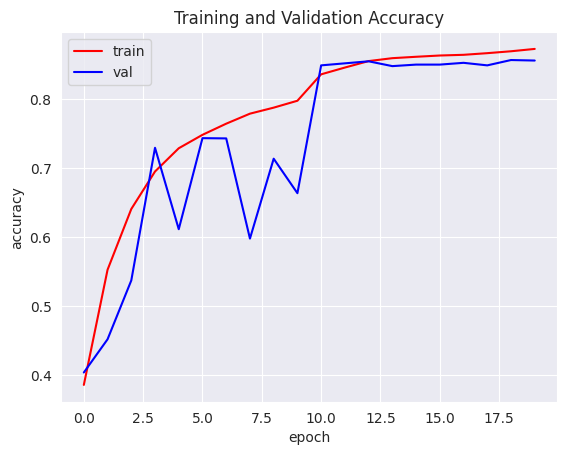

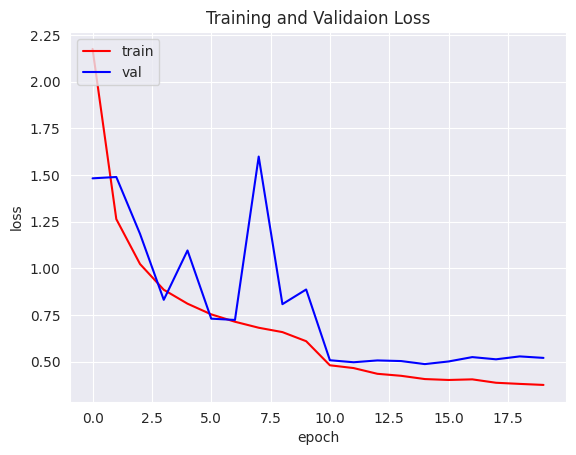

In [64]:
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



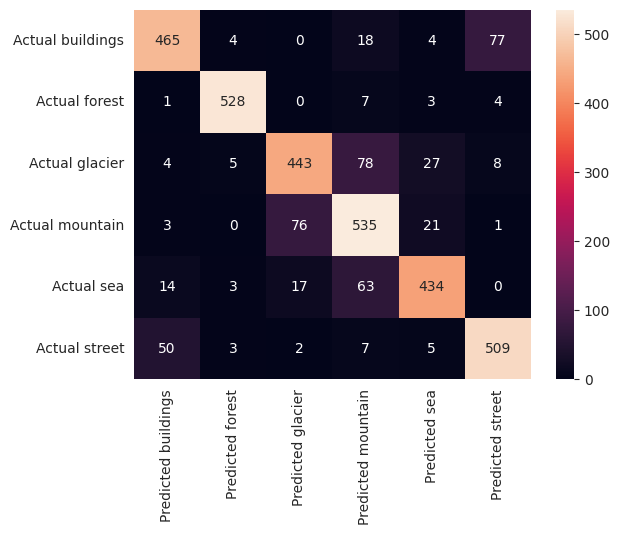

In [65]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_final = model_final.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

# **Last Model Exp**

## **Modeling**

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

last_model = Sequential([
    Input(shape=(150,150,3)),
    data_augmentation,
    Conv2D(10, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Conv2D(20, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Conv2D(40, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Conv2D(80, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Flatten(),
    Dense(80, activation='relu'),
    Dropout(0.3),
    Dense(40, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.5),
    #Dense(1, activation='sigmoid')
    Dense(train_generator.num_classes, activation='softmax')
])

# Kompilasi model
last_model.compile(optimizer='adamW',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

last_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 15, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 80)             │       313,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │            6

 Total params: 356,836 (1.36 MB)

 Trainable params: 356,536 (1.36 MB)

 Non-trainable params: 300 (1.17 KB)

#callback

In [67]:
#Callback untuk memberhentikan proses epoch ketika model tidak bisa mencapai nilai val_accuracy yang lebih tinggi

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25, #selama 25 epoch berikutnya
    restore_best_weights=True
)

In [68]:
import os
import numpy as np

# Calculate class counts
label_names = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

# Hitung jumlah gambar di setiap label
label_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in label_names}

# Total gambar dan jumlah kelas
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Hitung class weights
class_weights = {
    idx: total_samples / (num_classes * count)
    for idx, (label, count) in enumerate(label_counts.items())
}

# Cetak hasil
print("Label names:", label_names)
print("Class weights:", class_weights)

Label names: ['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']
Class weights: {0: 1.0285839929639402, 1: 0.9729617304492513, 2: 1.067549064354176, 3: 1.0299427564949362, 4: 0.9311305732484076, 5: 0.9819479429051218}


In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model training with validation
history_last= last_model.fit(
    train_generator,
    epochs=100,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.2096 - loss: 1.9641 - val_accuracy: 0.3701 - val_loss: 1.5139
Epoch 2/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3166 - loss: 1.6061 - val_accuracy: 0.2451 - val_loss: 1.7136
Epoch 3/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.3814 - loss: 1.5286 - val_accuracy: 0.4013 - val_loss: 1.4139
Epoch 4/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.3988 - loss: 1.4373 - val_accuracy: 0.4737 - val_loss: 1.2537
Epoch 5/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4201 - loss: 1.4006 - val_accuracy: 0.4531 - val_loss: 1.2910
Epoch 6/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4465 - loss: 1.3395 - val_accuracy: 0.5072 - val_loss: 1.2821
Epoch 7/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4710 - loss: 1.2985 - val_accuracy: 0.4296 - val_loss: 1.2893
Epoch 8/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4837 - loss: 1

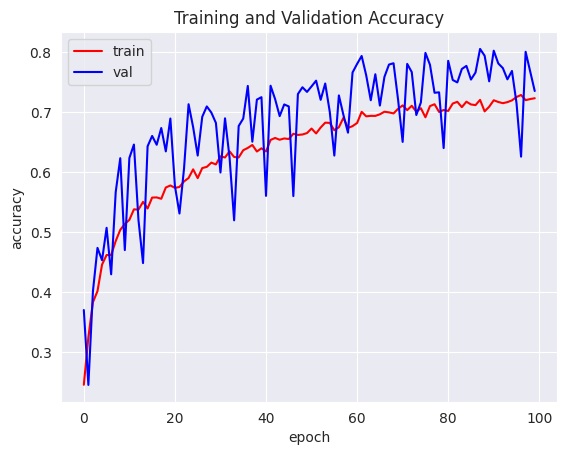

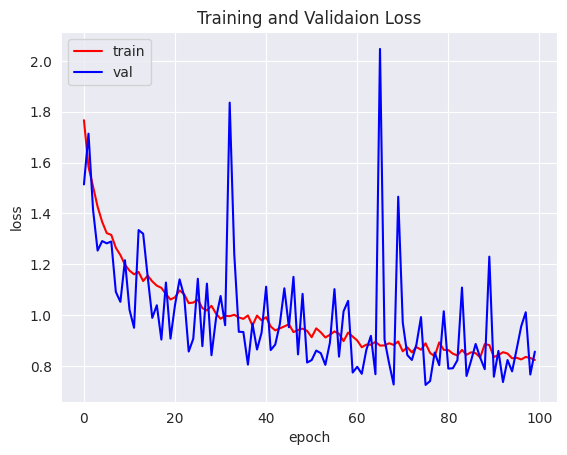

In [70]:
acc = history_last.history['accuracy']
val_acc = history_last.history['val_accuracy']
loss = history_last.history['loss']
val_loss = history_last.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8659    0.8187    0.8416       568
      forest     0.9724    0.9724    0.9724       543
     glacier     0.8234    0.7841    0.8033       565
    mountain     0.7556    0.8412    0.7961       636
         sea     0.8785    0.8173    0.8468       531
      street     0.8497    0.8837    0.8664       576

    accuracy                         0.8523      3419
   macro avg     0.8576    0.8529    0.8544      3419
weighted avg     0.8545    0.8523    0.8526      3419



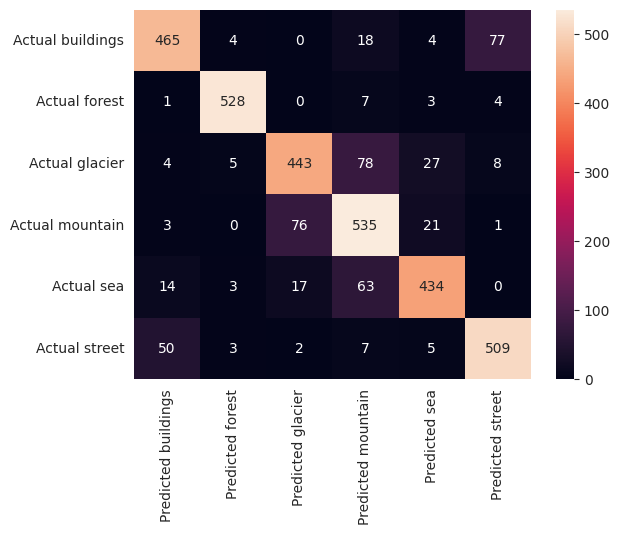

In [71]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()

preds_last = last_model.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_2, axis=1)  # Convert probabilities to class indices

# Get unique class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_classes)

# Create DataFrame with dynamic labels
cm_df = pd.DataFrame(data=cm,
                     index=["Actual " + label for label in class_labels],
                     columns=["Predicted " + label for label in class_labels])
sns.heatmap(cm_df, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                           y_pred=pred_classes,
                           target_names=class_labels, # Use dynamic labels here as well
                           digits=4))

#Save Base Model

3419/3419 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


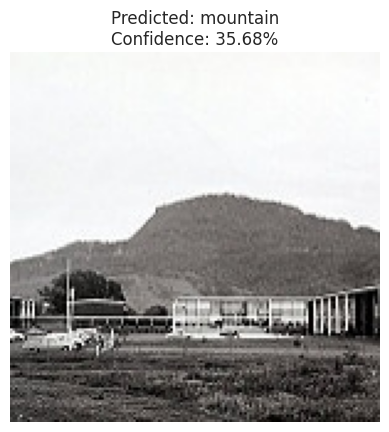

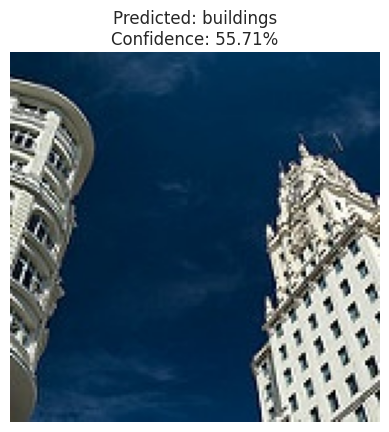

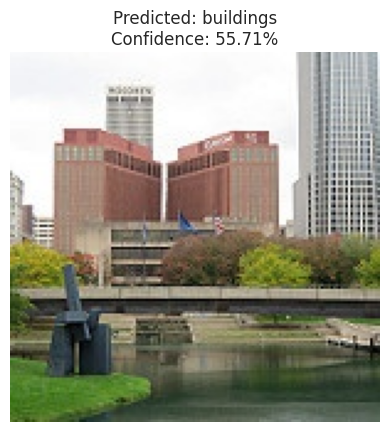

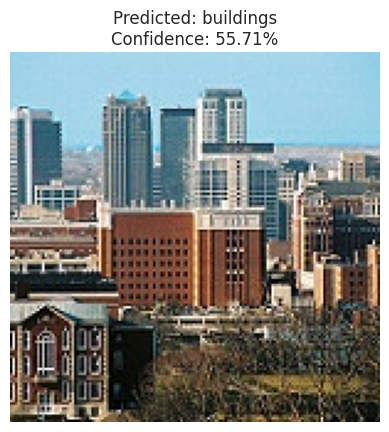

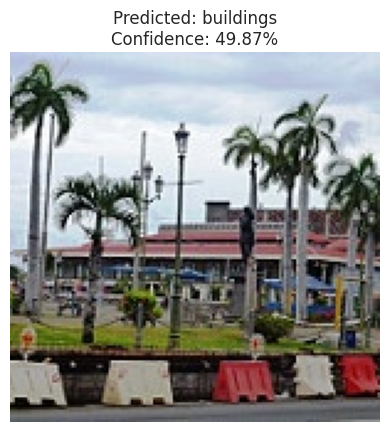

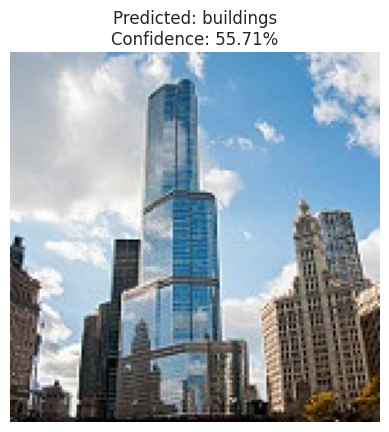

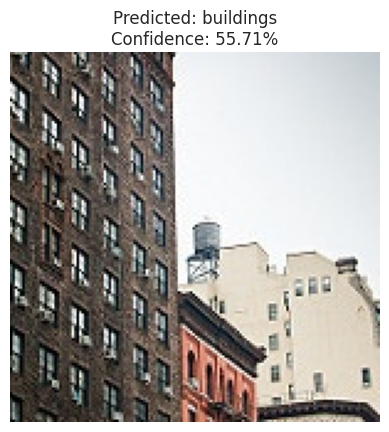

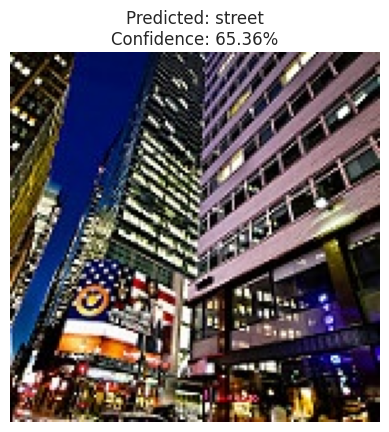

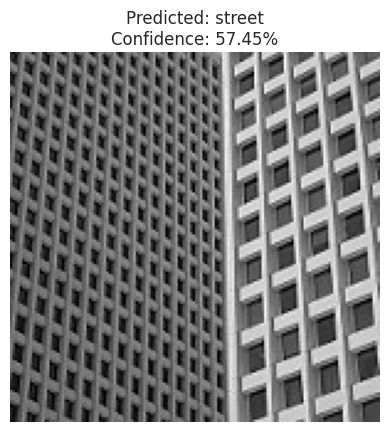

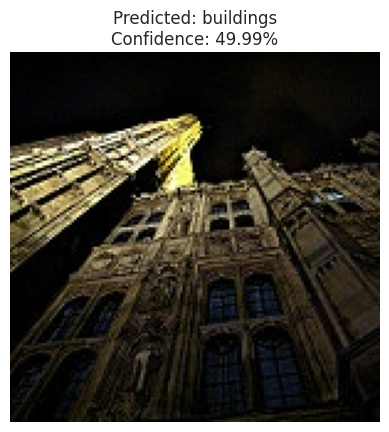

In [72]:
# Ambil nama kelas dari test_generator
class_names = list(test_generator.class_indices.keys())

# Prediksi semua gambar dalam test_generator
probabilities = last_model.predict(test_generator, verbose=1)

# Loop 10 gambar pertama
for index, probability in enumerate(probabilities[:10]):
    image_path = TEST_DIR + "/" + test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)

    predicted_class = np.argmax(probability)
    confidence = probability[predicted_class]

    plt.title(f"{confidence * 100:.2f}% {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()


## **Save all model type (SavedModel, TFLite, TFJS)**

In [73]:
import os
import tensorflow as tf

# 1. Buat model inference dari model training
inference_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(10, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(20, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(40, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(80, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Salin bobot dari last_model
inference_model.set_weights(last_model.get_weights())

# 2. Simpan SavedModel
os.makedirs("submission/saved_model", exist_ok=True)
inference_model.export("submission/saved_model")

# 3. Simpan ke TFLite
os.makedirs("submission/tflite", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# 3.1 Tambah label.txt
with open("submission/tflite/label.txt", "w") as f:
    f.write("Cats\nDogs")

# 4. Konversi ke TensorFlow.js
!pip install tensorflowjs

os.makedirs("submission/tfjs_model", exist_ok=True)
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='StatefulPartitionedCall' \
    --saved_model_tags=serve \
    submission/saved_model \
    submission/tfjs_model

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_44')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136618080608016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080605136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080604368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080606864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080607248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080604752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080608400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080606288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616182128976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616182126864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13661

In [74]:
import shutil

# Membuat file zip dari folder submission
shutil.make_archive("/content/submission", 'zip', "/content/submission")

# Mengunduh file zip yang sudah dibuat
from google.colab import files
files.download("/content/submission.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Saved Model Only**

In [75]:
import shutil
from google.colab import files as colab_files  # beri alias agar tidak konflik

# Ekspor model
last_model.export("saved_model/my_model")

# Kompres ke zip
shutil.make_archive("my_model", 'zip', "saved_model/my_model")

# Unduh file zip ke komputer lokal
colab_files.download("my_model.zip")

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136618080600912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080600720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080746576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616204739664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616204746576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616204742544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616204744464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616204743504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616204746000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616204744656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366162

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **TFLite Only**

In [76]:
# Buat ulang model tanpa layer augmentasi
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

# Model untuk inference (tanpa data_augmentation)
inference_model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(20, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(40, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(80, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(80, activation='relu'),
    Dropout(0.3),
    Dense(40, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Salin bobot dari model aslimu (last_model)
inference_model.set_weights(last_model.get_weights())

# Simpan dalam format SavedModel
inference_model.export("saved_model/inference_model")
print("Model disimpan ke folder: saved_model/inference_model")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/inference_model")
tflite_model = converter.convert()

# Simpan sebagai .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
print("Model berhasil dikonversi ke TFLite: model.tflite")

# Unduh dari Colab (jika kamu pakai Google Colab)
from google.colab import files
files.download("model.tflite")

Saved artifact at 'saved_model/inference_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_67')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136618080612048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080612816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080613584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080743312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080611856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080738704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080611088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136618080613392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616182127056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136616182127248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **TFJS Only**

In [77]:
#install tensorflowjs
!pip install tensorflowjs

In [78]:
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_format=tfjs_graph_model \
                        saved_model/my_model tfjs_model/

2025-04-24 08:02:41.225646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745481761.258554   30356 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745481761.268507   30356 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-24 08:02:49.401201: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745481769.401394   30356 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [79]:
import shutil
from google.colab import files

# Kompres folder tfjs_model
shutil.make_archive("tfjs_model", 'zip', "tfjs_model")

# Download file ZIP
files.download("tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>